# Part 2c : Building the modular network

### Overview

This Notebook continues where Part 2 left. We work with the original paper once again, but this rebuilding the modular network.

This Notebook builds the network in a more efficient way.

### Chapters


### 0. Plot configuration


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

%load_ext autoreload
%autoreload 2

plt.style.use(["science"])
plt.rcParams["figure.figsize"] = (12, 7)


## 1. Building the network


In [2]:
import nest
import nest.raster_plot
import pylab

nest.ResetKernel()
n = 4  # number of threads'
dt = 0.1

nest.SetKernelStatus(
    {"local_num_threads": n, "resolution": dt, "overwrite_files": True}
)

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Mar  7 2023 05:58:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Apr 27 02:37:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


### 1b. Building the modular network


What we now want to do is to take the same number of _total_ neurons as before, but change their topology by rewiring connections. Something like the follow figure:

<img src="./../img/neural_columns.png" width="600">

The paper uses a recursive method for splitting the random network into submodules, where

- inhibitory synapses are always rewired within the module
- excitatory synapses are rewired within with the probability $R_{ex}$,

The paper also provides a formula for computing inter-modular connection probabilities:

Splitting a module into $m$ submodules of equal size at each level, the connection density between the modules of the $i$ th level is:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e006.gif" width="500">

where $i = 1,…,l$, if a network is rewiring into a l-level HMN. The connection density within each unit of the network, that is, the l-level module, is

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e007.gif" width="500">


In [3]:
import seaborn as sns
from matplotlib.colors import LogNorm
from classes.hmn_network import HMN_network

"""
hmn_network_dummy = HMN_network()
connection_density = hmn_network_dummy.plot_connection_density() 
sns.set(font_scale=1.2)

cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
sns.clustermap(
    data=connection_density,
    annot=True,
    norm=LogNorm(vmin=10**-5, vmax=2 * 10**-1),
    fmt="d",
    cmap="Blues",
    annot_kws={"size": 16},
)
sns.heatmap(
    connection_density,
    norm=LogNorm(vmin=10**-5, vmax=2 * 10**-1),
    cmap="gray",
)

"""

'\nhmn_network_dummy = HMN_network()\nconnection_density = hmn_network_dummy.plot_connection_density() \nsns.set(font_scale=1.2)\n\ncmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)\nsns.clustermap(\n    data=connection_density,\n    annot=True,\n    norm=LogNorm(vmin=10**-5, vmax=2 * 10**-1),\n    fmt="d",\n    cmap="Blues",\n    annot_kws={"size": 16},\n)\nsns.heatmap(\n    connection_density,\n    norm=LogNorm(vmin=10**-5, vmax=2 * 10**-1),\n    cmap="gray",\n)\n\n'

## 2. Configure input stimulations


Papers on criticality uses different types of stimulations. Here, we'll use two types of stimulation:

1. All-but-sharp: All modules, one node, continous stimulation.
2. Few-but-wide: Few modules, most nodes, continous stimulation.

TODO

3. Resolve chaos: Spark the network with 180 Hz for 50 ms.


In [4]:
import numpy as np

len_submodule = 625
expected_global_spike_rate = 50


def compute_spikes_per_ms(n_neurons, hz):
    print("N neurons", n_neurons)
    return n_neurons * (hz / 1000)


def get_all_but_sharp_stimulation(stop=10_000, rate_hz=8):
    """
    1. Stimulate all modules, but only 25 neurons per module.
    """
    print("All but sharp, mHz =", rate_hz * 1_000)

    all_but_sharp_stimulation = {
        "poisson_config": {
            "rate": rate_hz * 1000,
            "stop": stop,
        },
        "stimulate_module_ids": np.arange(1, 17),
        "stimulate_module_ratio": 0.04,
    }
    spikes_per_ms = compute_spikes_per_ms(
        n_neurons=all_but_sharp_stimulation["stimulate_module_ratio"]
        * len_submodule
        * 16,
        hz=all_but_sharp_stimulation["poisson_config"]["rate"],
    )
    print("Expected spikes per ms: ", spikes_per_ms)
    return all_but_sharp_stimulation


def get_few_but_wide_stimulation(stop=10_000, rate_hz=4):
    """
    2. Stimulate 4 modules, but stimulate 50% of the neurons.
    """
    print("Few but wide, mHz =", rate_hz * 1_000)

    all_submodule_ids = np.arange(1, 17)
    size = 4
    modules_to_stimulate = np.random.choice(all_submodule_ids, size=size, replace=False)
    modules_to_stimulate = [3, 6, 9, 16]
    print(f"Stimulating module ids:, {modules_to_stimulate}")

    few_but_wide_stimulation = {
        "poisson_config": {
            "rate": rate_hz * 1000,
            "stop": stop,
        },
        "stimulate_module_ids": modules_to_stimulate,
        "stimulate_module_ratio": 0.5,
    }
    spikes_per_ms = compute_spikes_per_ms(
        n_neurons=few_but_wide_stimulation["stimulate_module_ratio"]
        * len_submodule
        * len(modules_to_stimulate),
        hz=few_but_wide_stimulation["poisson_config"]["rate"],
    )
    print("Expected spikes per ms: ", spikes_per_ms)
    return few_but_wide_stimulation

In [5]:
get_few_but_wide_stimulation(rate_hz=0.001)

Few but wide, mHz = 1.0
Stimulating module ids:, [3, 6, 9, 16]
N neurons 1250.0
Expected spikes per ms:  1.25


{'poisson_config': {'rate': 1.0, 'stop': 10000},
 'stimulate_module_ids': [3, 6, 9, 16],
 'stimulate_module_ratio': 0.5}

## 3. Run experiments


### 3.1 Measure spike data for various synapse configurations


Let's now explore this parameter space of synaptic weights, notice that our parameters are x10 the values on the graph:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_m/fncom-05-00030-g002.jpg" width="600">


**Generate spike events**


In [6]:
STIMULATION_SCHEME = get_few_but_wide_stimulation(stop=10_000, rate_hz=0.002)

Few but wide, mHz = 2.0
Stimulating module ids:, [3, 6, 9, 16]
N neurons 1250.0
Expected spikes per ms:  2.5


In [97]:
0.005 * 1000

5.0

Few but wide, mHz = 5.0
Stimulating module ids:, [3, 6, 9, 16]
N neurons 1250.0
Expected spikes per ms:  6.25
PARSING: 1.0 1.0
Using static synapses.

Apr 27 02:37:09 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Generating submodules of size 625, total network size 10000
Base network configured
Network fully built.

Apr 27 02:37:12 NodeManager::prepare_nodes [Info]: 
    Preparing 10012 nodes for simulation.
PARSING: 1.0 2.0
Using static synapses.
Generating submodules of size 625, total network size 10000

Apr 27 02:37:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10012
    Simulation time (ms): 4000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 27 02:37:44 SimulationManager::run [Info]: 
    Simulation finished.

Apr 27 02:37:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Base network configured
Network fully built.

Apr 27 02:37:45 NodeManage

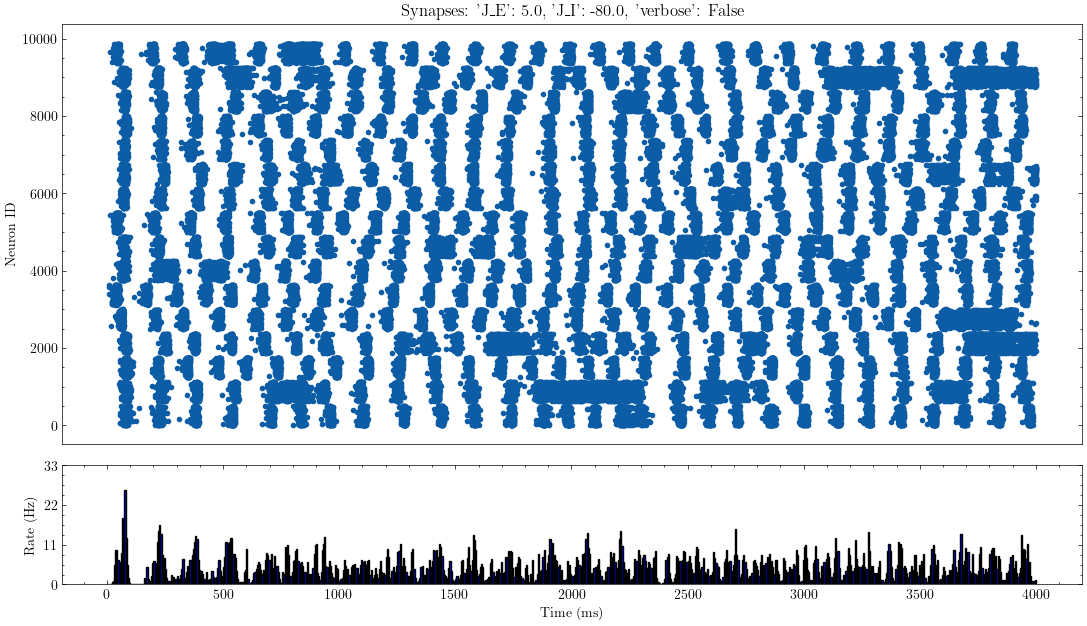

In [7]:
from classes.hmn_network import HMN_network


nest.ResetKernel()

# STIMULATION_SCHEME = get_all_but_sharp_stimulation(stop=10_000, rate_hz=0.008)
STIMULATION_SCHEME = get_few_but_wide_stimulation(stop=10_000, rate_hz=0.005)

#####################
strength = 10


params_1 = {
    "J_E": 0.5 * strength,
    "J_I": -8.0 * strength,
    "verbose": False,
}
noise_config = {
    # "module_ids": [2, 6, 11, 15],
    "module_ids": list(range(1, 17, 1)),
    "p": 1.0,
    # "stop": 200.0,
}

simtime = 4_000

DATA_TABLE = {}
within_delays = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
across_delays = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
tao_refs = [1.0, 2.0, 3.0, 4.0, 5.0]

index_data = tao_refs
column_data = within_delays

for col in column_data:
    DATA_TABLE[col] = {}
    for idx in index_data:
        print("PARSING:", col, idx)
        hmm_network_1 = HMN_network(**params_1, t_ref=idx)

        # Setting simulation parameters
        hmm_network_1.within_delay = col
        hmm_network_1.across_delay = col

        hmm_network_1.build()
        hmm_network_1.simulate(
            simtime=simtime,
            poisson_config=STIMULATION_SCHEME["poisson_config"],
            stimulate_module_ids=STIMULATION_SCHEME["stimulate_module_ids"],
            stimulate_module_ratio=STIMULATION_SCHEME["stimulate_module_ratio"],
            record_module_ids=list(range(1, 17)),
            # record_module_ids=[4],
            noise_config=noise_config,
        )
        spike_events = hmm_network_1.spikes_E.get("events")

        DATA_TABLE[col][idx] = spike_events


print(f"Stimulation scheme: {STIMULATION_SCHEME}")
hmm_network_1.plot(title=f"Synapses: {params_1}")

In [62]:
hmm_network_1.plot(title=f"Synapses: {params_1}")

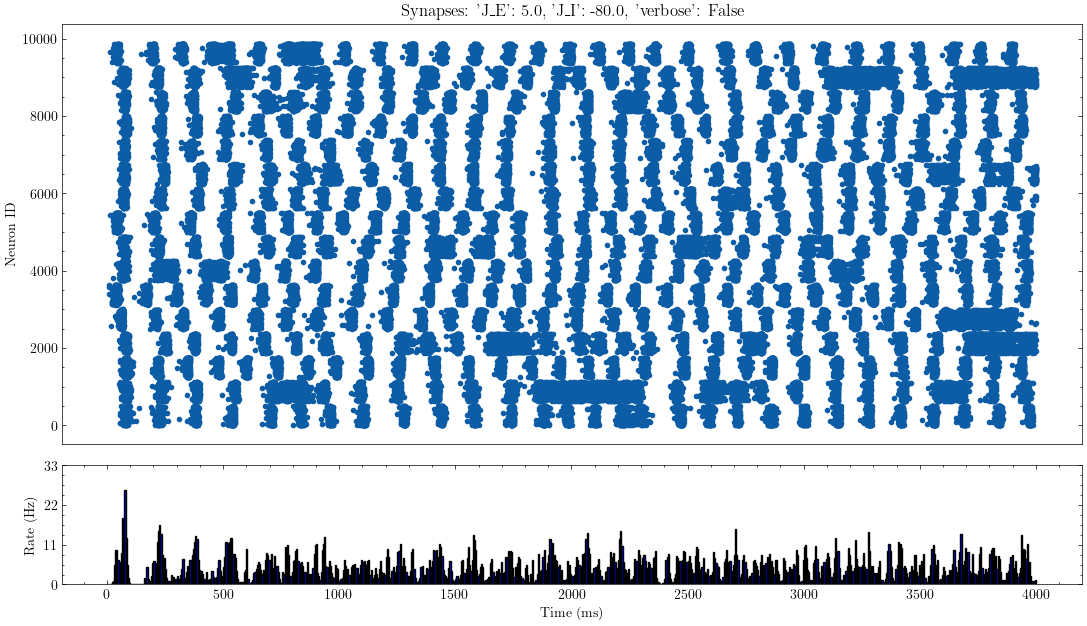

In [8]:
hmm_network_1.plot(title=f"Synapses: {params_1}")

**Compute avalanche and spike train distributions**


In [9]:
import pandas as pd

# Read saved data
df_data_table = pd.DataFrame(DATA_TABLE)
print("Index: \tTao Refs")
print("Column:\tWithin Delays")

df_data_table.head()

Index: 	Tao Refs
Column:	Within Delays


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
1.0,"{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 354...","{'senders': [3584, 3624, 9664, 3512, 3200, 344...","{'senders': [3584, 3624, 9664, 3512, 3200, 344..."
2.0,"{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 354...","{'senders': [3584, 3624, 9664, 3512, 3200, 344...","{'senders': [3584, 3624, 9664, 3512, 3200, 344..."
3.0,"{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 354...","{'senders': [3584, 3624, 9664, 3512, 3200, 344...","{'senders': [3584, 3624, 9664, 3512, 3200, 344..."
4.0,"{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 354...","{'senders': [3584, 3624, 9664, 3512, 3200, 344...","{'senders': [3584, 3624, 9664, 3512, 3200, 344..."
5.0,"{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3328, 351...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3200, 3512, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 332...","{'senders': [3584, 3624, 9664, 3512, 3200, 354...","{'senders': [3584, 3624, 9664, 3512, 3200, 344...","{'senders': [3584, 3624, 9664, 3512, 3200, 344..."


In [686]:
import pandas as pd


def convert_nested_array_to_list(cell):
    formatted_cell = {}
    for k, v in cell.items():
        formatted_cell[k] = list(v)
    return formatted_cell


def save_recorded_data(data, filename):
    df_test_test_formatted = data.applymap(convert_nested_array_to_list).astype(
        "string"
    )
    df_test_test_formatted.columns = df_test_test_formatted.columns.map(str)
    df_test_test_formatted.to_parquet(filename)


def read_recorded_data(filename):
    df_read_data = pd.read_parquet(filename)
    print("Data read. Evaluating cells.")
    return df_read_data.applymap(eval)


# save_recorded_data(df_data_table, "delay_vs_refactory_4000ms_few_but_wide_new_weight.parquet")
df_data_table = read_recorded_data(
    "delay_vs_refactory_4000ms_few_but_wide_new_weight.parquet"
)

Data read. Evaluating cells.


In [687]:
import pandas as pd
from classes.criticality_metrics import (
    fit_avalanche_sizes_to_power_distribution,
    fit_silent_period_to_power_distribution,
    fit_avalanche_duration_to_power_distribution,
    compute_gamma,
)


def plot_spike_events(df_spike_events, s=3):
    df_spike_events.plot(x="times", y="senders", kind="scatter", s=s)


def extract_module_spike_events(all_spike_events, len_submodule, N_total):
    df_all_spike_events = pd.DataFrame(all_spike_events)

    submodules_sender_ids = [
        (idx, idx + len_submodule) for idx in range(1, N_total + 1, len_submodule)
    ]
    submodule_spike_events = [
        df_all_spike_events.query(
            f"senders >= {sender_ids[0]} and senders < {sender_ids[1]}"
        )
        for idx, sender_ids in enumerate(submodules_sender_ids)
    ]
    return submodule_spike_events


def compute_power_law_factors(
    df_spike_events, compute_errors=False, silent_threshold=0.1
):
    _, m_silent_duration = fit_silent_period_to_power_distribution(
        df_spike_events,
        verbose=False,
        return_error=compute_errors,
    )
    _, m_size = fit_avalanche_sizes_to_power_distribution(
        df_spike_events,
        silent_threshold=silent_threshold,
        verbose=False,
        return_error=compute_errors,
    )
    _, m_duration = fit_avalanche_duration_to_power_distribution(
        df_spike_events,
        silent_threshold=silent_threshold,
        verbose=False,
        return_error=compute_errors,
    )

    gamma = compute_gamma(m_duration, m_size, includes_errors=compute_errors)
    return {
        "m_silent_duration": m_silent_duration,
        "m_duration": m_duration,
        "m_size": m_size,
        "gamma": gamma,
    }

In [688]:
def parse_raw_spike_recordings(
    all_spike_events,
    len_submodule,
    N_total,
    compute_errors=False,
    silent_threshold=0.1,
):
    submodule_spike_events = extract_module_spike_events(
        all_spike_events, len_submodule, N_total
    )
    power_parameters = compute_power_law_factors(
        submodule_spike_events, compute_errors, silent_threshold
    )

    return power_parameters

**Plot probability tables for each avalanche metric**


In [689]:
from classes.criticality_metrics import (
    get_avalanche_size_distribution,
    get_silent_time_distribution,
    get_avalanche_duration_distribution,
)

""" df_spike_events = pd.DataFrame(df_data_table.loc[5.0, "2.0"])

distr = get_avalanche_size_distribution([df_spike_events], silent_threshold=0.1)
x_label = "Avalanche Size"
y_label = "Normalized Frequency"
ax = (
    distr.reset_index()
    .query("index < 30")
    .plot(x="index", y=distr.columns[0], kind="scatter", s=6.0, fontsize=15)
)

ax.set_ylabel(y_label, fontsize=18)
ax.set_xlabel(x_label, fontsize=18) """

' df_spike_events = pd.DataFrame(df_data_table.loc[5.0, "2.0"])\n\ndistr = get_avalanche_size_distribution([df_spike_events], silent_threshold=0.1)\nx_label = "Avalanche Size"\ny_label = "Normalized Frequency"\nax = (\n    distr.reset_index()\n    .query("index < 30")\n    .plot(x="index", y=distr.columns[0], kind="scatter", s=6.0, fontsize=15)\n)\n\nax.set_ylabel(y_label, fontsize=18)\nax.set_xlabel(x_label, fontsize=18) '

Split the spike trains into submodule spike trains


In [690]:
df_parsed_data = df_parsed_data_20
# df_parsed_data = df_parsed_data_01

In [709]:
# df_parsed_data_10 = df_parsed_data.copy()

In [710]:
n_submodules = 16
N_total = 10_000
len_submodule = N_total // n_submodules

v_within_delay = 0.1
v_tao_ref = 0.5

# MAIN PARSING
df_parsed_data = df_data_table.applymap(
    parse_raw_spike_recordings,
    len_submodule=len_submodule,
    N_total=N_total,
    compute_errors=True,
    silent_threshold=1.0,
)

**Plot the various power coefficients**

The critical exponent of avalanche shapes: $\gamma = \frac{m*{period} - 1}{m*{activity} - 1} $


In [711]:
def plottable_3d_info(df: pd.DataFrame, include_errors):
    # https://stackoverflow.com/questions/36589521/how-to-surface-plot-3d-plot-from-dataframe
    """
    Transform Pandas data into a format that's compatible with
    Matplotlib's surface and wireframe plotting.
    """
    index = df.index
    columns = df.columns

    x, y = np.meshgrid(np.arange(len(columns)), np.arange(len(index)))
    z = np.array([[df[c][i] for c in columns] for i in index])
    z_errors = []

    if include_errors:
        z_errors = np.array([[value[1] for value in row] for row in z])
        z = np.array([[value[0] for value in row] for row in z])

    xticks = dict(ticks=np.arange(len(columns)), labels=columns)
    yticks = dict(ticks=np.arange(len(index)), labels=index)

    return x, y, z, z_errors, xticks, yticks


def add_error_bars(
    ax,
    x,
    y,
    z,
    z_errors,
):
    for i, z_coord in enumerate(np.concatenate(z)):
        ax.stem(
            np.concatenate(x)[i : i + 1],
            np.concatenate(y)[i : i + 1],
            z_coord + np.concatenate(z_errors)[i : i + 1],
            linefmt="--",
            bottom=z_coord,
        )

        ax.stem(
            np.concatenate(x)[i : i + 1],
            np.concatenate(y)[i : i + 1],
            z_coord - np.concatenate(z_errors)[i : i + 1],
            linefmt="--",
            bottom=z_coord,
        )


def plot_3d_surface(data, xlabel, ylabel, zlabel, title, include_errors=False):
    ### Transform to Matplotlib friendly format.
    x, y, z, z_errors, xticks, yticks = plottable_3d_info(data, include_errors)

    ### Set up axes and put data on the surface.
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    ax.plot_surface(x, y, z)
    if include_errors:
        add_error_bars(ax, x, y, z, z_errors)

    ### Customize labels and ticks (only really necessary with
    ### non-numeric axes).
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(
        title,
        pad=20,
        fontsize=14,
    )
    # ax.set_zlim3d(bottom=0)
    plt.xticks(**xticks)
    plt.yticks(**yticks)

    plt.show()

In [712]:
# %matplotlib inline 
%matplotlib qt

In [931]:
spike_events = df_data_table.loc[5.0, "3.0"]
df_spike_events = pd.DataFrame(spike_events)
submodule_spike_events = extract_module_spike_events(df_spike_events, 625, 10_000)
silent_threshold = 1.0

# plot_spike_events(df_spike_events)
fit_avalanche_sizes_to_power_distribution(
    submodule_spike_events,
    silent_threshold=silent_threshold,
    plot=True,
)

fit_avalanche_duration_to_power_distribution(
    submodule_spike_events,
    silent_threshold=silent_threshold,
    plot=True,
)

fit_silent_period_to_power_distribution(
    submodule_spike_events,
    silent_threshold=silent_threshold,
    plot=True,
    return_error=True,
)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


(2.652102354066542, 0.07083330405825503)

In [714]:
within_delay_label = "Within synapse delay [ms]"
across_delay_label = "Across synapse delay [ms]"
synaptic_delay_label = "Synapse delay [ms]"
neuron_refactory_label = "Neuron refactory period [ms]"

xlabel = synaptic_delay_label
ylabel = neuron_refactory_label

df_plot_gamma = df_parsed_data.applymap(lambda x: x["gamma"])
df_plot_m_size = df_parsed_data.applymap(lambda x: x["m_size"])
df_plot_m_duration = df_parsed_data.applymap(lambda x: x["m_duration"])
df_plot_m_silent_duration = df_parsed_data.applymap(lambda x: x["m_silent_duration"])


plot_3d_surface(
    df_plot_gamma,
    xlabel,
    ylabel,
    "$\gamma$",
    f"Criticality factor $\gamma$ as a function of synaptic delay \nand neuronal refactory time",
    include_errors=True,
)


plot_3d_surface(
    df_plot_m_size,
    xlabel,
    ylabel,
    "$\\beta$",
    f"Avalanche size exponent $\\beta$ as a function of synaptic delay \nand neuronal refactory time",
    include_errors=True,
)

plot_3d_surface(
    df_plot_m_duration,
    xlabel,
    ylabel,
    "$\kappa$",
    f"Avalanche duration exponent $\kappa$ as a function of synaptic delay \nand neuronal refactory time",
    include_errors=True,
)

plot_3d_surface(
    df_plot_m_silent_duration,
    xlabel,
    ylabel,
    "$l$",
    f"Avalanche silent period exponent $l$ as a function of synaptic delay \nand neuronal refactory time",
    include_errors=True,
)

In [715]:
compute_gamma(m_duration=2.0, m_size=1.5, includes_errors=False)

2.0

In [716]:
from classes.criticality_metrics import (
    plot_avalanche_sizes_distribution,
    plot_silent_period_distribution,
)

spike_events = df_data_table.loc[5.0, 1.0]
df_spike_events = pd.DataFrame(spike_events)
submodule_spike_events = extract_module_spike_events(spike_events, 625, 10_000)

""" fit_avalanche_sizes_to_power_distribution(
    submodule_spike_events, silent_threshold=0.1, plot=True
) """

KeyError: 1.0

### 4. Quantify the synaptic delay effect


**Melt data**


In [ ]:
def melt_data(data, value_name, var_name, index_name, includes_errors=False):
    melted_data = data.melt(
        ignore_index=False, value_name=value_name, var_name=var_name
    ).reset_index(names=index_name)

    if includes_errors:
        melted_data[value_name] = melted_data[value_name].apply(lambda x: x[0])
    return melted_data

**Fit to multiple distributions**


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm


def normalize_and_split(
    data,
    target_column,
    test_size=0.30,
    no_split=False,
    degree=2,
    normalize=False,
    standardize=False,
):
    predictors = list(set(list(data.columns)) - set(target_column))
    if normalize:
        print("Normalizing data")
        data[predictors] = (
            data[predictors].astype("float") / data[predictors].astype("float").max()
        )

    if standardize:
        data[predictors] = (
            data[predictors].astype("float") - data[predictors].astype("float").mean()
        ) / data[predictors].astype("float").std()
    X = data[predictors].values
    y = data[target_column].values

    # Expands: [a, b] -> [a, b, a^2, ab, b^2]
    print("Expanded: [a, b] -> [a, b, a^2, ab, b^2]")
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=40
    )
    if no_split:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.01, random_state=40
        )
        return X_train, X_train, y_train, y_train

    return X_train, X_test, y_train, y_test


def fit_multiple_models(X_train, X_test, y_train, y_test):
    models_dir = {
        "Linear regression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(alpha=0.001),
        # "ElasticNet": ElasticNet(),
    }
    for name, model in models_dir.items():
        print(f"{name}: ")
        model.fit(X_train, y_train)
        print(f"- {model.coef_}")
        pred_test_model = model.predict(X_test)
        RMSE = np.sqrt(mean_squared_error(y_test, pred_test_model))
        R2 = r2_score(y_test, pred_test_model)

        print(f"- RMSE: {RMSE}, R2: {R2}")
        print()


def fit_multiple_models_V2(X_train, X_test, y_train, y_test):
    # fit linear regression model
    model = sm.OLS(y_train, X_train).fit()

    print(model.summary())

In [ ]:
df_melted_gamma = melt_data(
    df_plot_gamma.copy(),
    value_name="gamma",
    var_name="within_delay",
    index_name="refractory_period",
    includes_errors=True,
)

X_train, X_test, y_train, y_test = normalize_and_split(
    df_melted_gamma,
    target_column=["gamma"],
    no_split=True,
    degree=2,
    # normalize=False,
    # standardize=True,
)

fit_multiple_models_V2(X_train, X_test, y_train, y_test)

Expanded: [a, b] -> [a, b, a^2, ab, b^2]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     9.734
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           2.86e-06
Time:                        15:00:31   Log-Likelihood:                 2.9279
No. Observations:                  49   AIC:                             6.144
Df Residuals:                      43   BIC:                             17.50
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [ ]:
df_melted_size = melt_data(
    df_plot_m_size.copy(),
    value_name="beta",
    var_name="within_delay",
    index_name="refractory_period",
    includes_errors=True,
)

X_train, X_test, y_train, y_test = normalize_and_split(
    df_melted_size,
    target_column=["beta"],
    no_split=True,
    normalize=False,
    standardize=True,
)

fit_multiple_models_V2(X_train, X_test, y_train, y_test)

Expanded: [a, b] -> [a, b, a^2, ab, b^2]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     39.79
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           4.58e-15
Time:                        15:00:31   Log-Likelihood:                 51.769
No. Observations:                  49   AIC:                            -91.54
Df Residuals:                      43   BIC:                            -80.19
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [ ]:
df_melted_duration = melt_data(
    df_plot_m_duration.copy(),
    value_name="kappa",
    var_name="within_delay",
    index_name="refractory_period",
    includes_errors=True,
)

X_train, X_test, y_train, y_test = normalize_and_split(
    df_melted_duration,
    target_column=["kappa"],
    no_split=True,
    degree=2,
    normalize=False,
)

fit_multiple_models_V2(X_train, X_test, y_train, y_test)

Expanded: [a, b] -> [a, b, a^2, ab, b^2]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     29.37
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           7.71e-13
Time:                        15:01:03   Log-Likelihood:               -0.43051
No. Observations:                  49   AIC:                             12.86
Df Residuals:                      43   BIC:                             24.21
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [ ]:
df_melted_silent_duration = melt_data(
    df_plot_m_silent_duration.copy(),
    value_name="l",
    var_name="within_delay",
    index_name="refractory_period",
    includes_errors=True,
)

X_train, X_test, y_train, y_test = normalize_and_split(
    df_melted_silent_duration,
    target_column=["l"],
    no_split=True,
    normalize=False,
)

fit_multiple_models_V2(X_train, X_test, y_train, y_test)

Expanded: [a, b] -> [a, b, a^2, ab, b^2]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     199.1
Date:                Fri, 28 Apr 2023   Prob (F-statistic):           1.42e-28
Time:                        15:00:32   Log-Likelihood:                 67.862
No. Observations:                  49   AIC:                            -123.7
Df Residuals:                      43   BIC:                            -112.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      